# set things up and get the data

In [1]:
%%time
from Startup import *
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
df = sqlContext.sql("SELECT * FROM parquet.`s3://philipp-ghcnd/GHCND_WT08_1960_2020_US.parquet`")
pdf = df.toPandas()

finished standard imports
dict_items([('spark.cores.max', '4'), ('spark.default.parallelism', '10'), ('spark.executor.memory', '3g'), ('spark.app.name', 'Weather_PCA'), ('spark.executor.cores', '1'), ('spark.logConf', 'True')])
started SparkContext and SQLContext in 13.06 seconds
loaded weather.parquet in 7.21 seconds
loaded stations.parquet in 0.20 seconds
registered dataframes as tables in 0.20 seconds
CPU times: user 836 ms, sys: 68 ms, total: 904 ms
Wall time: 41.6 s


## I exported the dataframe in string data type because that's the only thing that worked, so convert back...

In [2]:
%%time
from ast import literal_eval
pdf['Values'] = pdf['Values'].apply(literal_eval) # think I saved it as string 
wt08_graphs=[]
for i in range(pdf.shape[0]):
    wt08_graphs.append(pdf.iloc[i,2])
wt08_graphs=np.stack(wt08_graphs)

CPU times: user 30.7 s, sys: 112 ms, total: 30.8 s
Wall time: 30.8 s


## compute means by year

In [3]:
%%time
wt08_byyear=[]
wt08_yearmean = []
years = np.unique(pdf['year'])
for year in years:
    wt08_thisyear = []
    for i in range(wt08_graphs.shape[0]):
        if pdf['year'][i] == year:
            wt08_thisyear.append(wt08_graphs[i,:])
    wt08_byyear.append(np.mean(wt08_thisyear, axis=0))
    wt08_yearmean.append(np.mean(wt08_thisyear))
wt08_byyear=np.stack(wt08_byyear)
print(wt08_byyear.shape)

(61, 365)
CPU times: user 31.3 s, sys: 0 ns, total: 31.3 s
Wall time: 31.3 s


## plot overall mean by year 

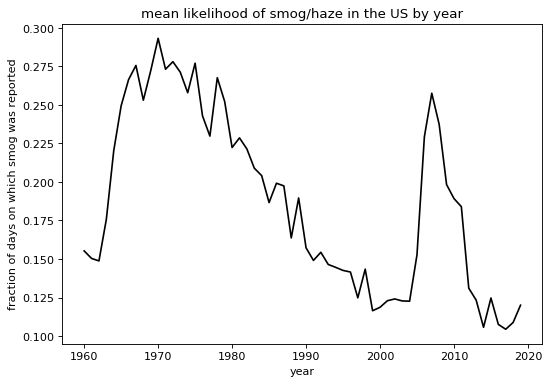

In [4]:
fig1 = plt.figure(figsize=(6, 4), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig1.add_axes([0,0,1,1])
ax1.plot(years[:-1],wt08_yearmean[:-1],color='black',linestyle='-')
ax1.set_title('mean likelihood of smog/haze in the US by year')
ax1.set_ylabel('fraction of days on which smog was reported')
ax1.set_xlabel('year')

In [5]:
## plot 

In [6]:
wt08_byyear_mean = np.mean(wt08_byyear[:-1,:], axis=0)
wt08_byyear_std = np.std(wt08_byyear[:-1,:], axis=0)

In [7]:
from matplotlib import cm
colmap = cm.get_cmap('jet', len(years)-1)
colors = colmap(range(len(years)-1))

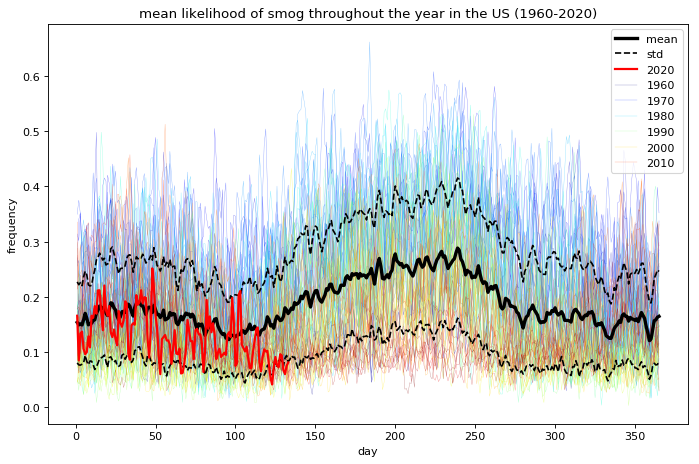

In [8]:
fig2 = plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax2 = fig2.add_axes([0,0,1,1])
theLines = []
for i in range(len(years)-1):
    yrplot, = ax2.plot(np.arange(1,366),wt08_byyear[i,:],color=colors[i,:3],alpha=0.5,lw=0.3,label=str(years[i]))
    if int(years[i]) % 10 == 0:
        theLines.append(yrplot)
stdplot, = ax2.plot(np.arange(1,366),wt08_byyear_mean+wt08_byyear_std,color='black',linestyle='--',label='std')
ax2.plot(np.arange(1,366),wt08_byyear_mean-wt08_byyear_std,color='black',linestyle='--')
meanplot, = ax2.plot(np.arange(1,366),wt08_byyear_mean,color='black',lw=3,label='mean')
mean2020, = ax2.plot(np.arange(1,134),wt08_byyear[-1,:133],color='red',alpha=1,lw=2,label='2020')
ax2.set_title('mean likelihood of smog throughout the year in the US (1960-2020)')
ax2.set_ylabel('frequency')
ax2.set_xlabel('day')
allLines = [meanplot, stdplot, mean2020]
for i in range(len(theLines)):
    allLines.append(theLines[i])
ax2.legend(handles=allLines)